In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from data_cleaner import *
from room_energy import energyLossAllRooms, energy_to_building

In [2]:
df_fcu_sth_raw = pd.read_csv('data/Gnd floor FCU Sth 16032020.csv')
df_fcu_nth_raw = pd.read_csv('data/Gnd floor FCU North 16032020.csv')
df_ahu_raw = pd.read_csv('data/Gnd AHU multi list 16032020.csv')
df_chiller_boiler_raw = pd.read_csv('data/more_Data/chillers boilers thermal Feb 23032020.csv')
room_info_raw = pd.read_csv('data/Room Details.csv')

df_ltb_temps = create_temp_df(df_fcu_sth_raw, df_fcu_nth_raw, df_ahu_raw)
df_chiller_boiler_power = create_chiller_boiler_power_df(df_chiller_boiler_raw)
df_room_info = create_room_info_df(room_info_raw)

In [4]:
df_energy_room_change = energyLossAllRooms(df_ltb_temps, df_room_info)
df_energy_external = energy_to_building(df_ltb_temps, df_room_info)

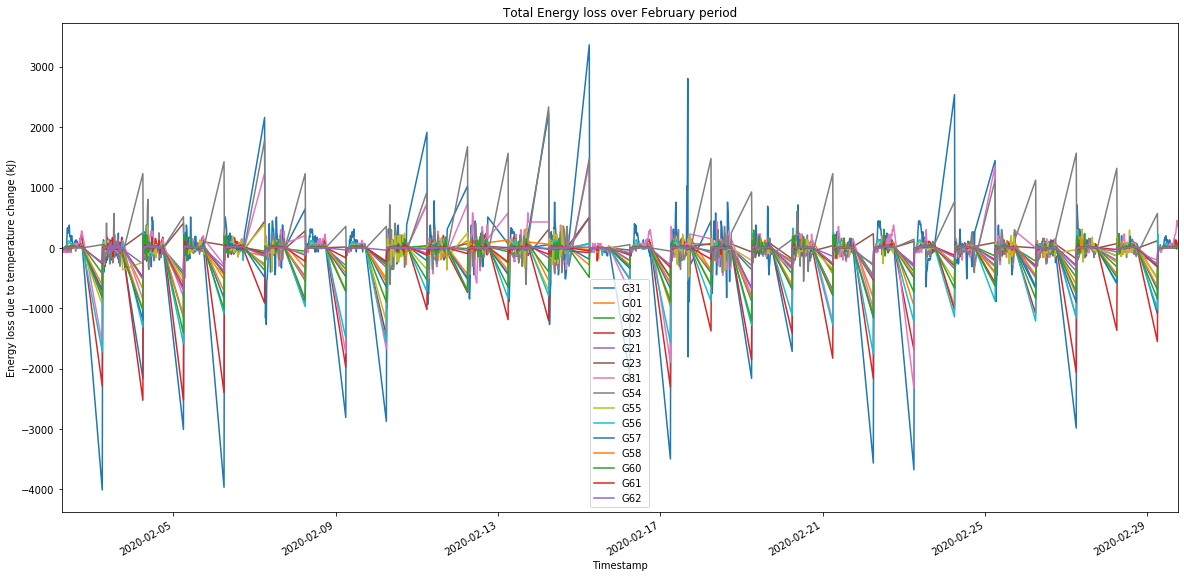

In [25]:
 # Get current axis
fig= plt.figure(figsize=(20,10))
ax = plt.gca()
ax.set_title("Total Energy loss over February period")
ax.set_ylabel("Energy loss due to temperature change (kJ)")
for col in df_energy_room_change.columns:
    df_energy_room_change[col].plot(kind='line', ax=ax, legend=True)
plt.show()

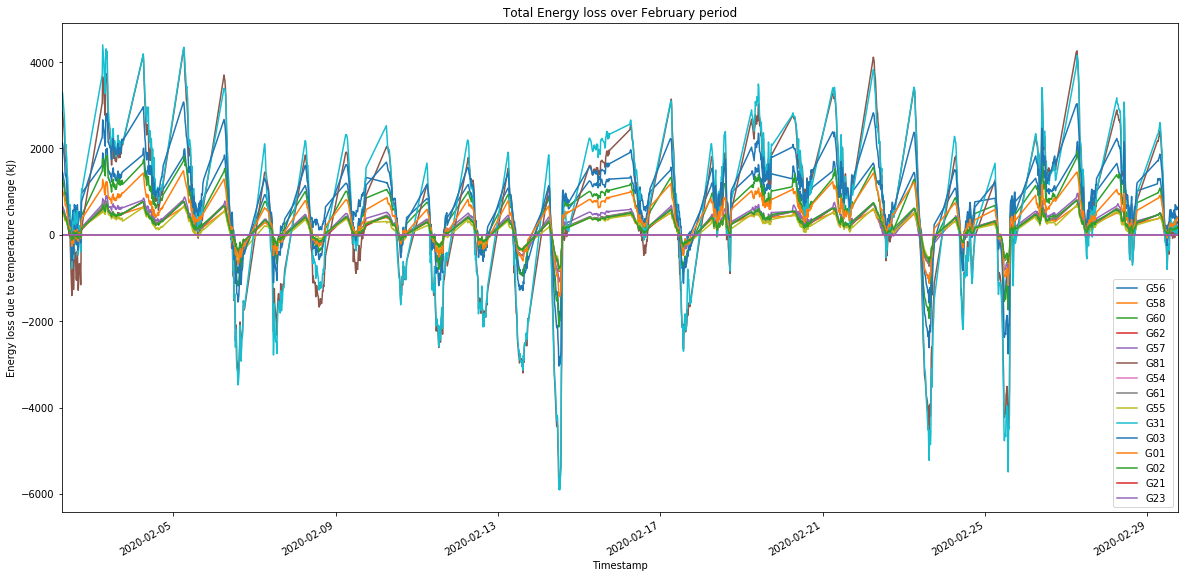

In [26]:
 # Get current axis
fig= plt.figure(figsize=(20,10))
ax = plt.gca()
ax.set_title("Total Energy loss over February period")
ax.set_ylabel("Energy loss due to temperature change (kJ)")
for col in df_energy_external.columns:
    df_energy_external[col].plot(kind='line', ax=ax, legend=True)
plt.show()